# Model Development: Credit-Score
<img src="../assets/credit-pic.jpg" alt="Title-Pic">

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pandas import Series, DataFrame
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})

# Data

In [2]:
MODEL_DATA = np.load("../model_data/credit_score_prep_data.npz", allow_pickle=True)
X_train = MODEL_DATA["inputs"]
y_train = MODEL_DATA["targets"]
DATA_COLUMN_NAMES = MODEL_DATA["input_column_names"]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((127608, 45), (15951, 45), (15951, 45)), ((127608,), (15951,), (15951,)))

# Helper Functions

In [3]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [4]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [5]:
def print_top_rankings(cv_results, top=10):
    sorted_zipped_report = sorted(
        zip(
            cv_results["params"], 
            cv_results["mean_test_score"], 
            cv_results["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")
        

In [6]:
def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy:\t{f1_score_test}\t|\tTrain-Accuracy:\t{accuracy_score_train}")
    print(f"F1-Score:\t{accuracy_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')


In [7]:
def print_feature_importance(model):
    return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

# Build the Model

## Model1: GradientBoost Model

In [8]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train);

Accuracy:	0.8031489835073541	|	Train-Accuracy:	0.8399630117234029
F1-Score:	0.804024826029716	|	Train-F1-Score:	0.8389128026813858

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      5310
           1       0.80      0.73      0.77      5420
           2       0.79      0.90      0.84      5221

    accuracy                           0.80     15951
   macro avg       0.81      0.81      0.80     15951
weighted avg       0.81      0.80      0.80     15951



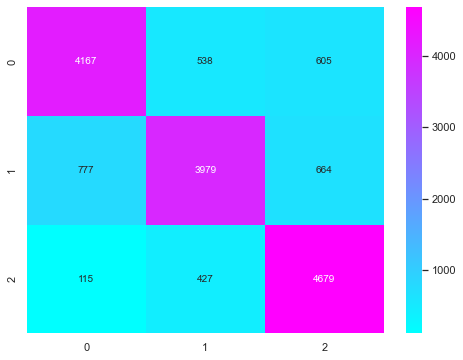

In [9]:
print_model_classification_report(xgb_model, X_test, y_test)

In [10]:
xgb_model.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [11]:
print_feature_importance(xgb_model)

Credit_Mix_Good                                       0.171433
Credit_Mix_Standard                                   0.115590
Payment_Behaviour_Low_spent_Large_value_payments      0.056354
Payment_Behaviour_High_spent_Small_value_payments     0.050998
Credit_Mix_Bad                                        0.047328
Payment_Behaviour_Low_spent_Small_value_payments      0.044921
Payment_Behaviour_High_spent_Medium_value_payments    0.043733
Payment_Behaviour_High_spent_Large_value_payments     0.036945
Payment_Behaviour_Low_spent_Medium_value_payments     0.035859
Outstanding_Debt                                      0.031200
Num_Credit_Card                                       0.019651
Has_PayRisk_Loan                                      0.017887
Num_Credit_Inquiries                                  0.017170
Has_Personal_Loan                                     0.017133
Interest_Rate                                         0.014595
Has_Estate_Loan                                       0

In [12]:
xgb_tmp_model = XGBClassifier(nthread=-1,)

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "learning_rate": [0.1],
    "min_child_weight": [3],
    "n_estimators": [700],
    "eta": [0.05],
    "gamma": [1],
    "subsample": [0.8],
    "max_depth": [10],
    "colsample_bytree": [0.8]
}

In [13]:
xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=2, scoring="f1_macro", verbose=3)

xgb_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END colsample_bytree=0.8, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=700, subsample=0.8;, score=0.859 total time= 2.2min
[CV 2/2] END colsample_bytree=0.8, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=700, subsample=0.8;, score=0.858 total time= 2.1min


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.8], 'eta': [0.05],
                         'eval_metric': ['logloss'], 'gamma': [1],
                         'learning_rate': [0.1], 'max_depth': [10],
                         'min_child_weight': [3], 'n_estimators': [700],
                         'subsample': [0.8]},
             scoring='f1_macro', verbose=3)

In [14]:
print_top_rankings(xgb_grid_model.cv_results_, 10)

Rank: 1	Score: 0.8584530764859177
Param: {'colsample_bytree': 0.8, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 700, 'subsample': 0.8}



Accuracy:	0.8834011141568366	|	Train-Accuracy:	0.9850557958748668
F1-Score:	0.8838317346874804	|	Train-F1-Score:	0.9850206425833269

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5310
           1       0.87      0.80      0.83      5420
           2       0.91      0.94      0.92      5221

    accuracy                           0.88     15951
   macro avg       0.88      0.88      0.88     15951
weighted avg       0.88      0.88      0.88     15951



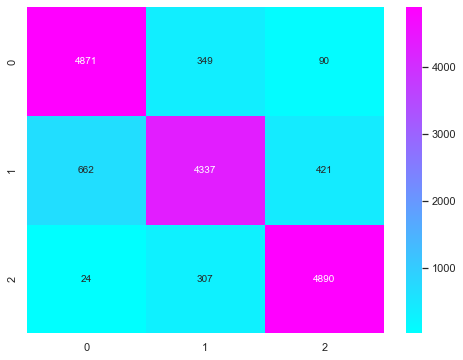

In [15]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_test, y_test)

In [16]:
xgb_best_model = xgb_grid_model.best_estimator_

## Model2: K-Nearest-Neighbor KNN

In [17]:
knn_model = KNeighborsClassifier(3)
knn_model.fit(X_train, y_train);

Accuracy:	0.8563248190962272	|	Train-Accuracy:	0.9194642969092847
F1-Score:	0.8624537646542536	|	Train-F1-Score:	0.9168534457617469

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5310
           1       0.93      0.65      0.76      5420
           2       0.86      0.98      0.91      5221

    accuracy                           0.86     15951
   macro avg       0.87      0.86      0.86     15951
weighted avg       0.87      0.86      0.86     15951



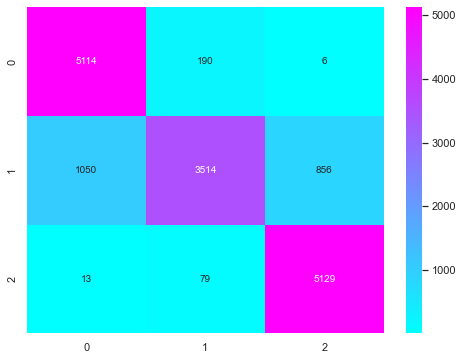

In [18]:
print_model_classification_report(knn_model, X_test, y_test)

In [19]:
knn_tmp_model = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": np.arange(3, 5, 2),
    "metric": ["manhattan"],
    "weights": ["distance"]
}

In [20]:
knn_grid_model = GridSearchCV(knn_tmp_model, knn_grid_params, cv=2, scoring="f1_macro", verbose=3)

knn_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.855 total time=  20.6s
[CV 2/2] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.854 total time=  20.4s


GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan'], 'n_neighbors': array([3]),
                         'weights': ['distance']},
             scoring='f1_macro', verbose=3)

In [21]:
print_top_rankings(knn_grid_model.cv_results_, 10)

Rank: 1	Score: 0.8544269201419771
Param: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}



Accuracy:	0.8805837090586385	|	Train-Accuracy:	1.0
F1-Score:	0.8837690426932481	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      5310
           1       0.92      0.72      0.81      5420
           2       0.89      0.98      0.93      5221

    accuracy                           0.88     15951
   macro avg       0.89      0.89      0.88     15951
weighted avg       0.89      0.88      0.88     15951



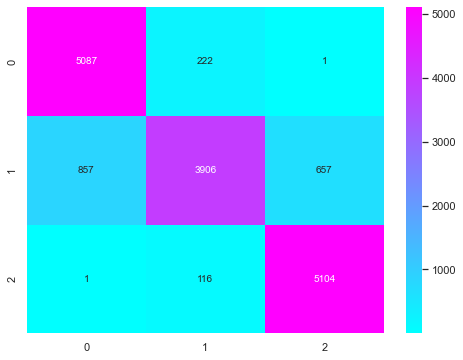

In [22]:
print_model_classification_report(knn_grid_model.best_estimator_, X_test, y_test)

In [23]:
knn_best_model = knn_grid_model.best_estimator_

## Model3: RandomForest

In [24]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train);

Accuracy:	0.8816687131755042	|	Train-Accuracy:	0.9999843270014419
F1-Score:	0.8828913547739954	|	Train-F1-Score:	0.9999843233053133

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5310
           1       0.90      0.77      0.83      5420
           2       0.89      0.95      0.92      5221

    accuracy                           0.88     15951
   macro avg       0.88      0.88      0.88     15951
weighted avg       0.88      0.88      0.88     15951



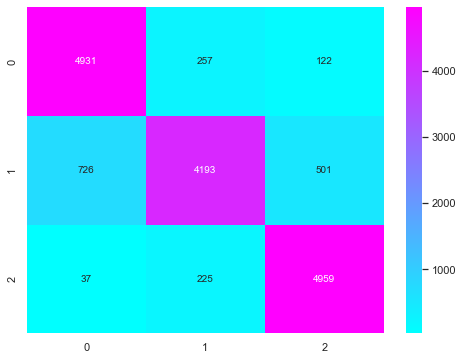

In [25]:
print_model_classification_report(rf_model, X_test, y_test)

In [26]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": [90],
    "min_samples_split": [7],
    "min_samples_leaf": [6],

    # BaggingClassifier params
    "n_estimators": [100],
    "max_samples": [0.95],
    "bootstrap": [True]
}

In [27]:
rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=2, scoring="f1_macro", verbose=3)

rf_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.95, min_samples_leaf=6, min_samples_split=7, n_estimators=100;, score=0.790 total time=   9.7s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.95, min_samples_leaf=6, min_samples_split=7, n_estimators=100;, score=0.787 total time=   9.6s


GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [90], 'max_samples': [0.95],
                         'min_samples_leaf': [6], 'min_samples_split': [7],
                         'n_estimators': [100]},
             scoring='f1_macro', verbose=3)

In [28]:
print_top_rankings(rf_grid_model.cv_results_, 10)

Rank: 1	Score: 0.7882292616887959
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.95, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 100}



Accuracy:	0.8389292026075462	|	Train-Accuracy:	0.9070747915491192
F1-Score:	0.8410757946210269	|	Train-F1-Score:	0.9054786261902766

              precision    recall  f1-score   support

           0       0.85      0.89      0.86      5310
           1       0.86      0.71      0.78      5420
           2       0.82      0.93      0.87      5221

    accuracy                           0.84     15951
   macro avg       0.84      0.84      0.84     15951
weighted avg       0.84      0.84      0.84     15951



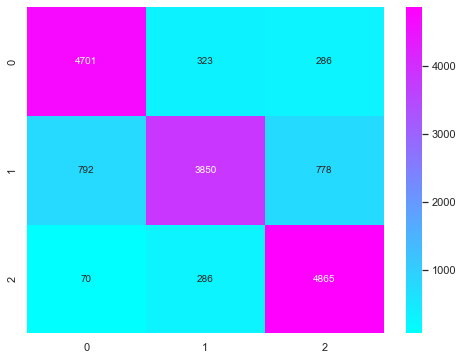

In [29]:
print_model_classification_report(rf_grid_model.best_estimator_, X_test, y_test)

In [30]:
rf_best_model = rf_model

## Model4: Decision Tree

In [31]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train);

Accuracy:	0.7941311713985096	|	Train-Accuracy:	1.0
F1-Score:	0.7936806469813805	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      5310
           1       0.74      0.73      0.74      5420
           2       0.84      0.85      0.84      5221

    accuracy                           0.79     15951
   macro avg       0.79      0.79      0.79     15951
weighted avg       0.79      0.79      0.79     15951



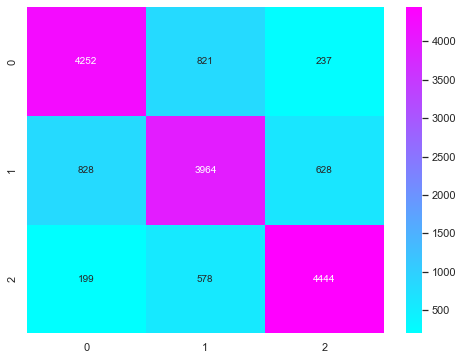

In [32]:
print_model_classification_report(dt_model, X_test, y_test)

In [33]:
dt_best_model = dt_model

## Model6: Voting Classifier

In [34]:
estimators_c1 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
    ("xgb", xgb_best_model),
    ("dt", dt_model)
]

estimators_c2 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
    ("xgb", xgb_best_model),
]

estimators_c3 = [
    ("rf", rf_best_model),
    ("knn", knn_best_model),
]

In [35]:
vc_model1 = VotingClassifier(estimators=estimators_c1, voting="soft")
vc_model2 = VotingClassifier(estimators=estimators_c2, voting="soft")
vc_model3 = VotingClassifier(estimators=estimators_c3, voting="soft")

vc_model1.fit(X_train, y_train)
vc_model2.fit(X_train, y_train)
vc_model3.fit(X_train, y_train);

Accuracy:	0.8893725132768499	|	Train-Accuracy:	1.0
F1-Score:	0.8904770860761081	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5310
           1       0.89      0.78      0.83      5420
           2       0.90      0.96      0.93      5221

    accuracy                           0.89     15951
   macro avg       0.89      0.89      0.89     15951
weighted avg       0.89      0.89      0.89     15951



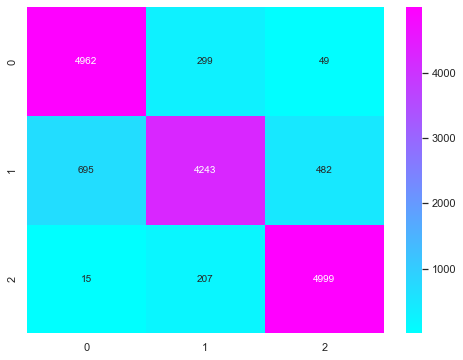

In [36]:
print_model_classification_report(vc_model1, X_test, y_test)

Accuracy:	0.8996475962758989	|	Train-Accuracy:	1.0
F1-Score:	0.9013854930725347	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5310
           1       0.93      0.77      0.84      5420
           2       0.91      0.97      0.94      5221

    accuracy                           0.90     15951
   macro avg       0.90      0.90      0.90     15951
weighted avg       0.90      0.90      0.90     15951



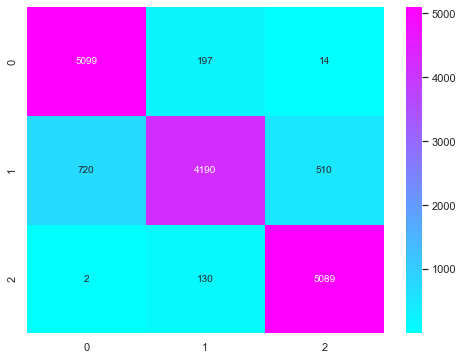

In [37]:
print_model_classification_report(vc_model2, X_test, y_test)

Accuracy:	0.8945675751542796	|	Train-Accuracy:	1.0
F1-Score:	0.8968716694878064	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5310
           1       0.93      0.75      0.83      5420
           2       0.90      0.98      0.94      5221

    accuracy                           0.90     15951
   macro avg       0.90      0.90      0.89     15951
weighted avg       0.90      0.90      0.89     15951



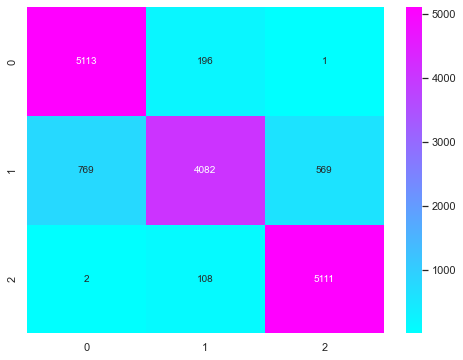

In [38]:
print_model_classification_report(vc_model3, X_test, y_test)

In [39]:
vc_model = vc_model2

## Mode7: Stacking Classifier

In [40]:
sc_model = StackingClassifier(estimators_c2, final_estimator=vc_model)
sc_model.fit(X_train, y_train);

Accuracy:	0.9014729040778815	|	Train-Accuracy:	0.997014293774685
F1-Score:	0.9026393329571814	|	Train-F1-Score:	0.9970154097950722

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5310
           1       0.91      0.79      0.85      5420
           2       0.92      0.97      0.94      5221

    accuracy                           0.90     15951
   macro avg       0.90      0.90      0.90     15951
weighted avg       0.90      0.90      0.90     15951



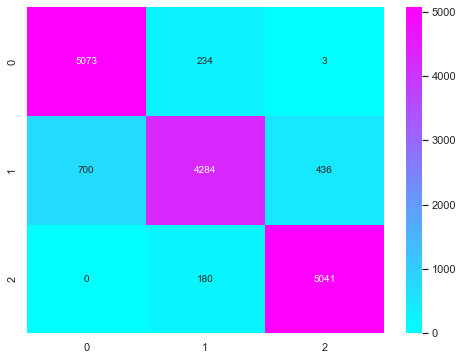

In [41]:
print_model_classification_report(sc_model, X_test, y_test)

In [42]:
estimators_c4 = [estimator for estimator in estimators_c2]
estimators_c4.append(("vc", vc_model))

sc_model2 = StackingClassifier(estimators_c4, final_estimator=vc_model)
sc_model2.fit(X_train, y_train);

Accuracy:	0.9036077423013245	|	Train-Accuracy:	0.9984640461413078
F1-Score:	0.9048962447495454	|	Train-F1-Score:	0.9984639697818563

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5310
           1       0.92      0.79      0.85      5420
           2       0.92      0.97      0.94      5221

    accuracy                           0.90     15951
   macro avg       0.91      0.91      0.90     15951
weighted avg       0.91      0.90      0.90     15951



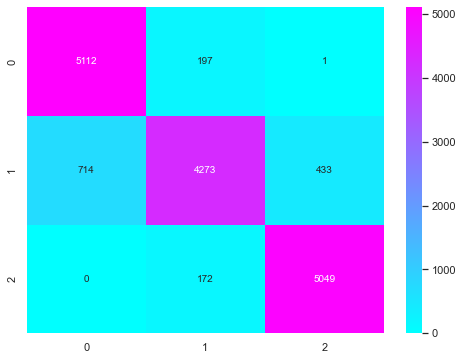

In [43]:
print_model_classification_report(sc_model2, X_test, y_test)

# Final Model Selection

Accuracy:	0.8978147852186263	|	Train-Accuracy:	1.0
F1-Score:	0.900695881135979	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5300
           1       0.92      0.77      0.84      5258
           2       0.91      0.98      0.94      5393

    accuracy                           0.90     15951
   macro avg       0.90      0.90      0.90     15951
weighted avg       0.90      0.90      0.90     15951



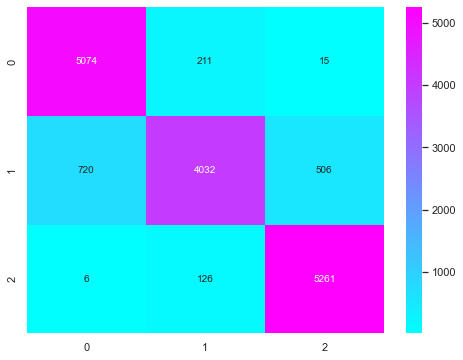

In [44]:
print_model_classification_report(vc_model, X_val, y_val)

Accuracy:	0.9019384184968434	|	Train-Accuracy:	0.9984640461413078
F1-Score:	0.9042693248072221	|	Train-F1-Score:	0.9984639697818563

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5300
           1       0.91      0.78      0.84      5258
           2       0.93      0.97      0.95      5393

    accuracy                           0.90     15951
   macro avg       0.91      0.90      0.90     15951
weighted avg       0.91      0.90      0.90     15951



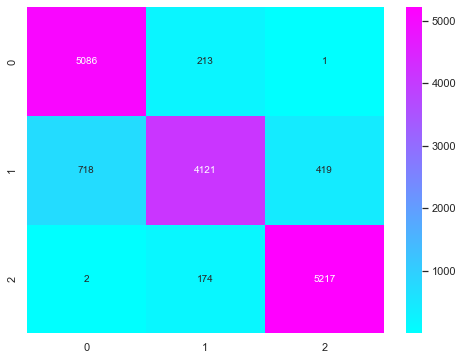

In [45]:
print_model_classification_report(sc_model2, X_val, y_val)

In [46]:
final_model = sc_model2

# Export the Model

In [47]:
model_path = export_model(final_model, "model_credit_score_classifier")

Accuracy:	0.9019384184968434	|	Train-Accuracy:	0.9984640461413078
F1-Score:	0.9042693248072221	|	Train-F1-Score:	0.9984639697818563

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5300
           1       0.91      0.78      0.84      5258
           2       0.93      0.97      0.95      5393

    accuracy                           0.90     15951
   macro avg       0.91      0.90      0.90     15951
weighted avg       0.91      0.90      0.90     15951



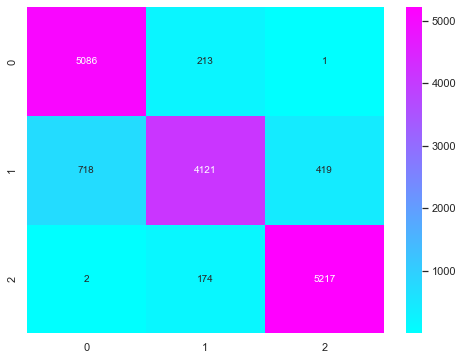

In [48]:
loaded_model = load_model(model_path)
print_model_classification_report(loaded_model, X_val, y_val)